# Falkner-Skan

As an example, let's solve the Falkner-Skan boundary layer equation - a familiar friend (or foe) to any battle-hardened aerodynamicist. The actual equation looks like this, as written in *Aerodynamics of Viscous Fluids* by Mark Drela (internal MIT draft), Eq. 3.32:

-----

With $F, U, S$ as a function of $\eta$, and with $()'$ denoting a derivative w.r.t. $\eta$:

$ F' = U $

$ U' = S $

$ S' = -\frac{1+a}{2} F S - a (1 - U^2) $

with the following three boundary conditions:

$ F(0) = 0 $

$ U(0) = 0 $

$ U(\infty) = 1 $, which we will approximate as $ U(10) = 1 $

And here, $a$ is some parameter that we know describing the edge velocity profile $u_e \propto x^a$ , typically in the range $-0.0904 < a < 2$ or so.

-----

Don't worry if this doesn't mean much to you - the actual equation is fairly inconsequential. This serves as a good example of an ODE for several reasons:

* It is nonlinear
* It is higher-order (third-order, specifically)
* It is a boundary value problem rather than an initial value problem, so explicit solution is difficult. (Note: explicit solution is not impossible; see the shooting method. However, for this problem, it is horribly unstable and the implicit solution that we will demonstrate is far superior.)

Let's solve the Falkner-Skan ODE, for the value of our constant $a = 0.1$.

First, we'll do boilerplate stuff that you all know by now, having read earlier tutorials:

In [1]:
import aerosandbox as asb
import aerosandbox.numpy as np

a = 0.1  # Initialize constants

opti = asb.Opti()  # Initialize an optimization/analysis environment

Now, let's define some derivatives:

In [2]:
n_points = 100  # Number of discretization points

eta = np.linspace(0, 10, n_points)  # Discretize eta from 0 to 10.

F = opti.variable(  # Create a variable F that represents some function F(eta)
    init_guess=eta + 10 / 3 * (1 - eta / 10) ** 3
)
U = opti.derivative_of(  # Create a variable U that represents a derivative of F(eta) with respect to eta.
    variable=F,
    with_respect_to=eta,
    derivative_init_guess=1 - (1 - eta / 10) ** 2
)
S = opti.derivative_of(  # Create a variable S that represents a derviative of U(eta) with respect to eta.
    variable=U,
    with_respect_to=eta,
    derivative_init_guess=0.2 * (1 - eta / 10)
)

Define the governing equations: (Note: derivatives between $F$, $U$, and $S$ were already constrained when they were initialized with the `opti.derivative_of()` syntax, so we just need to implement the last equation.)

In [3]:
opti.constrain_derivative(
    variable=S,
    with_respect_to=eta,
    derivative=-(1 + a) / 2 * F * S - a * (1 - U ** 2)
)

Then, define the boundary conditions:

In [4]:
opti.subject_to([
    F[0] == 0,
    U[0] == 0,
    U[-1] == 1,
])

[MX(fabs(opti0_lam_g_4)), MX(fabs(opti0_lam_g_5)), MX(fabs(opti0_lam_g_6))]

And solve:

In [5]:
sol = opti.solve()

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1389
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      200

Total number of variables............................:      300
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      300
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 0

Let's print a few of the results, and plot them:

In [6]:
print("U(eta) at each of our values of eta in `eta`:")
print(
    sol.value(U)
)

U(eta) at each of our values of eta in `eta`:
[0.         0.049641   0.09825533 0.14583071 0.19234757 0.23777988
 0.28209604 0.32525983 0.36723139 0.40796822 0.44742624 0.48556094
 0.52232842 0.55768654 0.59159604 0.62402158 0.65493275 0.68430497
 0.71212035 0.73836829 0.76304607 0.78615921 0.8077216  0.8277556
 0.84629175 0.86336854 0.87903181 0.89333412 0.90633399 0.918095
 0.92868483 0.93817429 0.9466363  0.95414489 0.96077428 0.96659792
 0.97168775 0.97611343 0.97994176 0.98323616 0.98605625 0.98845765
 0.9904917  0.99220545 0.99364164 0.99483878 0.99583131 0.99664977
 0.99732103 0.99786859 0.99831282 0.99867125 0.99895888 0.99918843
 0.99937063 0.99951444 0.99962734 0.99971548 0.9997839  0.99983673
 0.9998773  0.99990827 0.99993179 0.99994954 0.99996288 0.99997283
 0.99998023 0.99998568 0.99998969 0.99999262 0.99999474 0.99999627
 0.99999737 0.99999816 0.99999872 0.99999911 0.99999939 0.99999958
 0.99999971 0.99999981 0.99999987 0.99999991 0.99999994 0.99999996
 0.99999997 0.99999

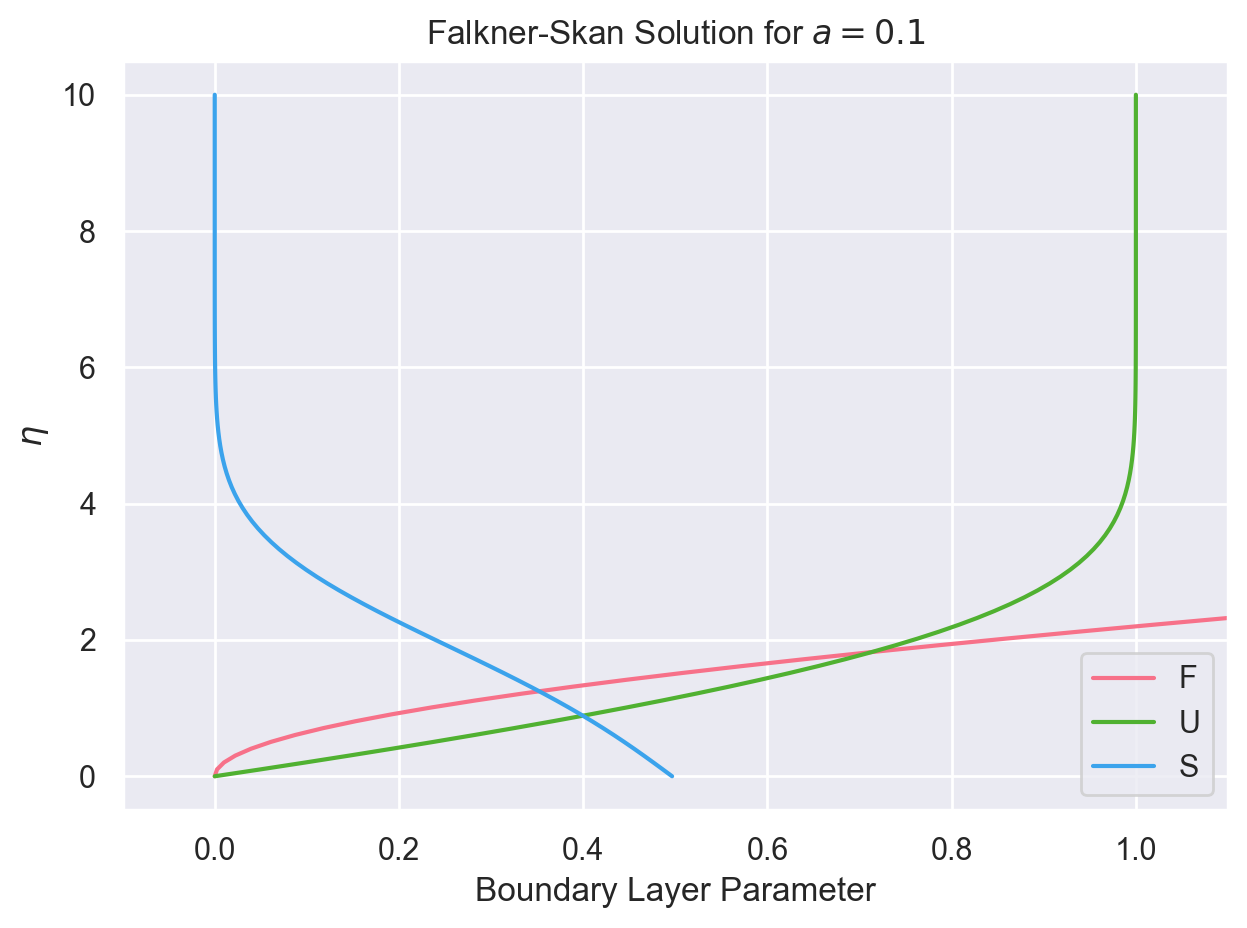

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette=sns.color_palette("husl", 3))

fig, ax = plt.subplots(1, 1, figsize=(6.4, 4.8), dpi=200)
for var in ["F", "U", "S"]:
    plt.plot(
        sol.value(eval(var)),
        eta,
        label=var
    )
plt.xlim(-0.1, 1.1)
plt.xlabel(r"Boundary Layer Parameter")
plt.ylabel(r"$\eta$")
plt.title(rf"Falkner-Skan Solution for $a = {a}$")
plt.tight_layout()
plt.legend()
plt.show()